In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# add the path for the src
import sys
sys.path.insert(0, '/path/to/gridworld/')

In [3]:
import numpy as np
import pickle

import os
from tqdm import tqdm
import cvxpy as cp

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pltlab

%matplotlib inline

# plt.rcParams['figure.dpi'] = 200
import seaborn as sns
sns.set(color_codes=True)

In [5]:
from gridworld.agents.tabular_base_agent import Agent
from gridworld.core.utils import direct_policy_evaluation, bounded_successive_approximation, default_termination

# Section 1 : Implementation of Le et al (2019)

## Section 1.1: Utility functions

### Utilities for Policy Iteration 

In [6]:
def make_cost_policy_iteration_operator(P, R, discount, **kwargs):
    """
    P: sat
    R: sa
    returns a operator that does 1 step of policy improvement
    via the Linear Programming formulation of the PI
    
    Imp: minimizes the cost!

    :param P: transition matrix
    """
    nstates = R.shape[0]
    nactions = R.shape[1]

    def lp_policy_iteration_operator(policy):
        # calculate the q-values
        v = direct_policy_evaluation(P, R, discount, policy)        
        Q = R + discount * np.einsum('sat,t -> sa', P, v)

        # final policy placeholder
        soln_pi = np.zeros((nstates, nactions))
        
        # greedy update 
        soln_pi[np.arange(nstates), np.argmin(Q,axis=1)] = 1.0
        return soln_pi

    return lp_policy_iteration_operator

In [7]:
def cost_policy_iteration(P, R, discount, max_iters = 25):
    """
    P: sat
    R: sa
    does policy iteration, starting from a random policy and doing 1-step PI based on LP
    """
    # create the operator 
    pi_operator = make_cost_policy_iteration_operator(P, R, discount)

    # create random pi
    nstates = R.shape[0]
    nactions = R.shape[1]
    
    random_policy = np.ones((nstates, nactions))/nactions

    pi_solution = bounded_successive_approximation(random_policy,
                                      operator=pi_operator,
                                      termination_condition=default_termination,
                                      max_limit= max_iters,)

    return pi_solution

###  Utilities for storing values

In [8]:
class ValueFunction(object):
    """
    From: https://github.com/clvoloshin/constrained_batch_policy_learning/blob/master/value_function.py
    """
    def __init__(self):
        '''
        Utility DS to store the previous values and policies
        '''
        self.prev_values = []
        
    def append(self, value):
        self.prev_values.append(value)

    def avg(self, append_zero=False):
        if append_zero:
            return np.hstack([np.mean(self.prev_values, 0), np.array([0])])
        else:
            return np.mean(self.prev_values, 0)

    def last(self, append_zero=False):
        if append_zero:
            return np.hstack([self.prev_values[-1], np.array([0])])
        else:
            return np.array(self.prev_values[-1])


### Online Learning Algorithm : Exponentiated Gradient (EG)

In [9]:
class ExponentiatedGradient(object):
    """
    Extended from: https://github.com/clvoloshin/constrained_batch_policy_learning/blob/master/exponentiated_gradient.py

    """
    def __init__(self, lambda_bound, number_of_constraints, eta=1., starting_lambda='uniform'):
        '''
        lambda_bound: hyper-param B in Alg 2
        eta: hyper-param \eta in Alg 2
        numb_constraints = (# of objectives) + 1
            additional 1 added for the phantom constraint for bounded norm (Sec 3, Le et al)
        '''
        self.eta = eta
        self.lambda_bound = lambda_bound
        self.number_of_constraints = number_of_constraints
        if starting_lambda == 'uniform':
            self.w_t = self.lambda_bound * np.ones(self.number_of_constraints) / self.number_of_constraints
        else:
            self.w_t = starting_lambda
            self.lambda_bound = np.sum(starting_lambda)

    def run(self, gradient):
        """
        This function implements Line 16 of Alg 2

        :param gradient: vector z_t
        Z_t[i]: of the form (J(i) <= tau)

        for maximizatio
        :return:
        """
        self.w_t = self.w_t/self.lambda_bound

        unnormalized_wt = self.w_t*np.exp(self.eta*gradient) # positive since working  w/ costs.
        self.w_t = self.lambda_bound*unnormalized_wt/sum(unnormalized_wt)
        return self.w_t


    def get(self):
        return self.w_t

## Section 1.2: Algorithm 2 of Le et al. (Batch Policy Learning with Constraints, ICML 2019)

In this part we create the agent class that extends the Algorithm 2 from Le et al (2019) to our setting. We name the agent as Lagrangian agent because the Alg 2 is based around on solving the Lagrangian of all objectives. We use the code provided by the authors from https://github.com/clvoloshin/constrained_batch_policy_learning/ and build on it. 

In [10]:
## Create the Lagrangian agent here! 

class Lagrangian(Agent):
    """
    Agent based on Le at al (2109)
    """
    def __init__(self,
                 coeff_list,
                 n_iter,
                 norm_bound,
                 lr_eta, 
                 dual_gap, 
                ):
        """

        :param termintation_condition: the function that decides when to stop the iterative procedure
        :param coeff_list: the list of lambda_parameters to try search over
        :param kwargs:
        """
        self.coeff_list = coeff_list
        self._name = "Lagrangian"
        
        # Hyper-params 
        self.n_iter = n_iter # hyper-param t in Line 2 of Alg 2
        self.lambda_bound = norm_bound # hyper-param B input to Alg 2
        self.lr_eta = lr_eta # hyper-param \eta input to Alg 2
        self.dual_gap = dual_gap # hyper-param \omega in Line 13 in Alg 2
        
        
        #init the containters
        self.reset()
    
    def reset(self):
        """flushes all the values for a fresh run"""
        # init the containers for storing value estimates
        self.U_vals = ValueFunction()
        self.R_vals = ValueFunction()
        self.C_vals = ValueFunction()
        
        # perf in true env
        self.true_R_vals = ValueFunction()
        self.true_C_vals = ValueFunction()
        
        # plotting utils
        self.safe_log = []
        self.performance_log_R = []
        self.performance_log_C = []
        self.gap_log = []

    def make_policy_iteration_operator(self, P, R, C, discount, 
                                       initial_distribution,
                                       coeffs, 
                                       pi_baseline,
                                       P_star,
                                       plotting=True,
                                      ):
        """
        Algorithm 2 of Le et al (2019)
        
        Estimated mdp parameters
        P: sat
        R: sa
        C: sa
        P_star: sat
        
        P_star required for the true policy evaluation that 

        coeffs: coefficients (\lambda_i) for each signal AND \lamba_i >= 0
        """
        # flush all the past info
        self.reset() 
        
        nstates = R.shape[0]
        nactions = R.shape[1]

        # these are the tau, the new constraints! 
        vR_pib_mhat = direct_policy_evaluation(P, - R, discount, pi_baseline) # -ve becasue we are now dealing with costs 
        pib_R_est_performance = sum(vR_pib_mhat * initial_distribution)
        
        
        vC_pib_mhat = direct_policy_evaluation(P, C, discount, pi_baseline)
        pib_C_est_performance = sum(vC_pib_mhat * initial_distribution)

        # tau = [R,C,0] (#constraints + 1)
        # the SPI constraints are on performance and the additional constraint is due to the bounded norm
        tau = [pib_R_est_performance, pib_C_est_performance, 0.]
        
        # initialize the online algo
        online_convex_algorithm = ExponentiatedGradient(self.lambda_bound, len(tau), self.lr_eta, starting_lambda='uniform')

        # init lambda (Line 1, Alg 2)
        lambdas = []
        lambdas.append(online_convex_algorithm.get())
        
        
        # Loggging/debugging
        vR_pib_true = direct_policy_evaluation(P_star, R, discount, pi_baseline) # +ve here, because just evaluating
        pib_R_true_performance = sum(vR_pib_true * initial_distribution)
        vC_pib_true = direct_policy_evaluation(P_star, C, discount, pi_baseline)
        pib_C_true_performance = sum(vC_pib_true * initial_distribution)
        
        # (Line 2, Alg 2)
        for t in tqdm(range(self.n_iter), disable=1 - plotting):
            # current_lambda 
            lamb = lambdas[-1]

            # the user objective
            U = -1. * (coeffs[0] * R - coeffs[1] * C) # negative because Le et al minimizing cost instead of maximize return
            
            # Do best response PI here and get new policy (Line 3)
            best_response_cost_fn = U + (lamb[0] * - R) + (lamb[1] * C) 
            pi_t = cost_policy_iteration(P=P, R=best_response_cost_fn, discount=discount)
            
            # Do PE here (Line 4,5)
            U_pi_t_hat, R_pi_t_hat, C_pi_t_hat = self.update_vals(pi_t, P, U, R, C, discount, initial_distribution, P_star)
                        
            # No need to compute pi_hat_t if we are already storing the values (Skip Line 6)
            
            # Take the averages here (Line 7)
            U_avg = self.U_vals.avg() 
            R_avg = self.R_vals.avg()
            C_avg = self.C_vals.avg()
            
            # Get the avg lambda (Line 8)
            lamb_avg = np.mean(lambdas, 0)
            
            # Get the min over lagrangian (Lines 9, 10, 12)
            L_min = self.min_of_lagrangian_over_policy(lamb_avg, tau, P, U, R, C, discount, initial_distribution)
                        
            # Compute the max over lagrangian (Line 11)
            G_avg = [R_avg, C_avg, 0]
            L_max = self.max_of_lagrangian_over_lambda(U_avg, G_avg, tau)
            
            # Check the duality gap here (Line 13)
            if L_max - L_min <= self.dual_gap:
                # Terminate the algorithm (Line 14)
                # As we are not storing all the policies so far, we just compute the avg of the true performance of the policies so far 
#                 true_R_perf = self.true_R_vals.avg()
#                 true_C_perf = self.true_C_vals.avg()                
#                 return true_R_perf, true_C_perf
                 break

            
            # Update the lambdas here (Line 15,16)
            G_last = np.array([R_pi_t_hat, C_pi_t_hat, 0.])
            gradient = G_last - tau
            lambda_t = online_convex_algorithm.run(gradient)

            # Append the updated lambda to the list
            lambdas.append(lambda_t)
            
            
            # Logging stuff 
            is_safe = (self.true_R_vals.avg() >= pib_R_true_performance) and (self.true_C_vals.avg() <= pib_C_true_performance)
            self.safe_log.append(is_safe)
            self.gap_log.append(L_max - L_min)
            self.performance_log_R.append(self.true_R_vals.avg())
            self.performance_log_C.append(self.true_C_vals.avg())
            if t%50==0 and plotting:
                print(f"Iter: {t}, Gap: {L_max - L_min:.3f}, Safe: {is_safe}") 
            
        # plot for loggging purpose
        if plotting:
            self.plot(pib_R_true_performance, pib_C_true_performance)
        
        # return the final performance
        true_R_perf = self.true_R_vals.avg()
        true_C_perf = self.true_C_vals.avg()       
        true_failure_rate = 1. - np.mean(self.safe_log)
                
        return true_R_perf, true_C_perf, true_failure_rate
            
        

       
    def update_vals(self, pi, P, U, R, C, discount, initial_distribution, P_star):
        """
        do policy evalutation and update the values
        """
        # Do PE here 
        # For user preferences based cost
        v_U_pi = direct_policy_evaluation(P, U, discount, pi)
        U_pi_hat = sum(v_U_pi * initial_distribution) 
            
        # For R  
        v_R_pi = direct_policy_evaluation(P, - R, discount, pi) # -ve because we are now working with costs
        R_pi_hat = sum(v_R_pi * initial_distribution) 
        
        # For C 
        v_C_pi = direct_policy_evaluation(P, C, discount, pi) 
        C_pi_hat = sum(v_C_pi * initial_distribution) 
        
        # store them
        self.U_vals.append(U_pi_hat)
        self.R_vals.append(R_pi_hat)
        self.C_vals.append(C_pi_hat)
        
        # now calculate the real performance in the true environment (only for R and C)
        # For R
        exact_v_R_pi = direct_policy_evaluation(P_star, R, discount, pi) 
        exact_R_pi = sum(exact_v_R_pi * initial_distribution) 
        # For C 
        exact_v_C_pi = direct_policy_evaluation(P_star, C, discount, pi) 
        exact_C_pi = sum(exact_v_C_pi * initial_distribution) 
        
        self.true_R_vals.append(exact_R_pi)
        self.true_C_vals.append(exact_C_pi)
        
        return U_pi_hat, R_pi_hat, C_pi_hat
        
    

    def min_of_lagrangian_over_policy(self, lamb_avg, tau, P, U, R, C, discount, initial_distribution):
        """
        Performs the steps in Line 9,10 and 12 of Alg 2
        """
        # Learn the pi_tilde (Line 9)
        avg_best_response_cost_fn = U + (lamb_avg[0] * - R) + (lamb_avg[1] * C) 
        pi_tilde = cost_policy_iteration(P=P, R=avg_best_response_cost_fn, discount=discount)
            
        # Eval the pi_tilde (Line 10)
        # For L (user preferences based cost)
        v_U_pi_tilde = direct_policy_evaluation(P, U, discount, pi_tilde)
        U_pi_tilde_hat = sum(v_U_pi_tilde * initial_distribution) 
            
        # For R  
        v_R_pi_tilde = direct_policy_evaluation(P, - R, discount, pi_tilde) # -ve because we are now working with costs
        R_pi_tilde_hat = sum(v_R_pi_tilde * initial_distribution) 
        
        # For C 
        v_C_pi_tilde = direct_policy_evaluation(P, C, discount, pi_tilde) 
        C_pi_tilde_hat = sum(v_C_pi_tilde * initial_distribution) 
        
        # Compute the L_min (Line 12)
        G_pi_tilde = np.array([R_pi_tilde_hat, C_pi_tilde_hat, 0.])
        L_min = U_pi_tilde_hat + np.dot(lamb_avg, (G_pi_tilde - tau))
        
        return L_min
        
       
    def max_of_lagrangian_over_lambda(self, U_avg, G_avg, tau):
        '''
        Line 11 of Alg 2
        
        The maximum of C(pi) + lambda^T (G(pi) - eta) over lambda is
        B*e_{k+1}, all the weight on the phantom index if G(pi) < eta for all constraints
        B*e_k otherwise where B is the l1 bound on lambda and e_k is the standard
        basis vector putting full mass on the constraint which is violated the most
        '''
        G_avg = np.array(G_avg)

        ## Calculate the max violating constraint here
        maximum = np.max(G_avg - tau)
        index = np.argmax(G_avg - tau)
        
        if maximum > 0:
            # if there is constraint that is being violated the most, put all weight on it
            lamb = self.lambda_bound * np.eye(1, len(tau), index).reshape(-1)
        else:
            # put all weight on the phantom lambda
            lamb = np.zeros(len(tau))
            lamb[-1] = self.lambda_bound
        
        # compute the lagrangian wrt this lambda
        L_max = U_avg + np.dot(lamb, (G_avg - tau))
        
        return L_max
    
    def plot(self, pib_R_true_performance, pib_C_true_performance):
        """
        plot how the training looks for debugging
        """
        # Create sub-plot for 4 plots
        # Top safety, duality gap
        # Bottom R_perf, C_perf (w/ baseline performance)
        fig, axes = plt.subplots(2, 2, figsize=(10,10))
        
        # num of iters
        x_range = np.arange(len(self.safe_log)) 
        
        
        safe_rate = np.zeros(len(self.safe_log))
        for i in range(len(self.safe_log)):
            safe_rate[i] = 1. - np.mean(self.safe_log[:i+1])
        axes[0, 0].plot(x_range, safe_rate)
        axes[0, 0].set_ylabel("Failure rate")
#         axes[0, 0].set_xlabel("iterations")
        axes[0, 0].set_title("Safety")
        
        axes[0, 1].plot(x_range, self.gap_log)
        axes[0, 1].set_ylabel("Dual gap")
        axes[0, 1].set_title("Duality gap")
        
        axes[1, 0].plot(x_range, self.performance_log_R)
        axes[1, 0].set_ylabel("Returns vs baseline (dotted black line)")
        axes[1, 0].axhline(y= pib_R_true_performance, label = "baseline for 1st obj", linestyle="--", c='black')
        axes[1, 0].set_title("Performance for 1st objective")
        axes[1, 0].legend()
        
        neg_costs = [-1. * i for i in self.performance_log_C]
        axes[1, 1].plot(x_range, neg_costs)
        axes[1, 1].set_ylabel("Returns vs baseline (dotted red line)")
        axes[1, 1].axhline(y= - pib_C_true_performance, label = "baseline for 2nd obj", linestyle="--", c='red')
        axes[1, 1].set_title("Performance for 2nd objective")
        axes[1, 1].legend()
        
        plt.show()
        


# Section 2: Sanity checks for the implementation


## Section 2.1: Env and data generation
In this section we will first create a CMDP environment and test if our implementation works for this environment. First, we will create a CMDP and calculate the optimal policy $(\pi^{\star})$. Then we will use that to create a baseline policy ($\pi_{b}$) based on the ratio parameter $\rho$. Finally, we generate the dataset ($\mathcal{D}$) and estimate the MDP parameters $\hat{P}$.

In [11]:
# env parameters 
ENV_NAME = 'large_grid-200'
ENV_TRIES = 1000
GAMMA = 0.99 
COST_LIM = 2.0
SEED = 0

In [12]:
from gridworld.envs.creation_utils import create_env
from gridworld.core.utils import cmdp_dual_lp, generate_dataset, estimate_model

np.random.seed(SEED)

i_env = 0
while i_env < ENV_TRIES:
    try:
        i_env += 1
        env = create_env(ENV_NAME)
        P_star, R_star, C_star, initial_distribution = env.compute_cmdp_matrices()

        #  Compute \pi_* using the dual formulation
        v_opt, c_opt, pi_opt = cmdp_dual_lp(P_star, R_star, C_star, GAMMA, COST_LIM, initial_distribution)

        # TODO: fix this hack later
        if np.isnan(pi_opt).any():
            # skip the current/wrong solution
            # continue
            raise Exception("Nans in the pi_opt")

        # if able to compute the solution successfully then break
        break
    except Exception:
        # If there is no optimal policy, try with a new environment
        print(f"Couldn't find optimal, trying again.")
        
i_env

/home/mila/s/satijah/tabular-bcrl/gridworld/core/utils.py:139: RuntimeWarning: invalid value encountered in true_divide
  pi_opt = pi_opt / pi_opt.sum(axis=1)[:, None]


Couldn't find optimal, trying again.


2

In [13]:
# the parameters for the quality of the baseline and the dataset

NB_TRAJ = 50
RATIO =  0.9
COEFFS = (0.0, 1.0)

In [14]:
nstates = env.nstates
nactions = env.nactions

# create a uniform random policy for mixing with the ratio specified with
pi_random = np.ones((nstates, nactions)) / nactions

pi_baseline = RATIO * pi_opt + (1-RATIO) * pi_random

# generate dataset
trajectories, batch_transitions = generate_dataset(NB_TRAJ, env, pi_baseline)

P_hat = estimate_model(batch_transitions, nstates, nactions)
P_hat.shape

/home/mila/s/satijah/tabular-bcrl/gridworld/core/utils.py:198: RuntimeWarning: invalid value encountered in true_divide
  est_P = count_P / np.sum(count_P, 2)[:, :, np.newaxis]


(100, 4, 100)

## Section 2.2: Sanity checks

In this section we validate that our implementation is correct. 

### Check-I: Duality-gap converges 

First we check if for a given user preference we observe the duality gap reducing and converging.

In [15]:
# hyper-parameters for the Lagrangian agent (Le et al, Alg 2)
N_ITER = 250 
NORM_BOUND = 10 
LR_ETA = 0.01 
DUAL_GAP = 0.01 

 12%|█▏        | 29/250 [00:00<00:01, 141.87it/s]

Iter: 0, Gap: 1039.113, Safe: True


 30%|██▉       | 74/250 [00:00<00:01, 145.61it/s]

Iter: 50, Gap: 24.555, Safe: True


 48%|████▊     | 119/250 [00:00<00:00, 147.62it/s]

Iter: 100, Gap: 13.576, Safe: True


 72%|███████▏  | 181/250 [00:01<00:00, 149.61it/s]

Iter: 150, Gap: 9.726, Safe: True


 92%|█████████▏| 229/250 [00:01<00:00, 150.41it/s]

Iter: 200, Gap: 7.695, Safe: True


100%|██████████| 250/250 [00:01<00:00, 148.41it/s]


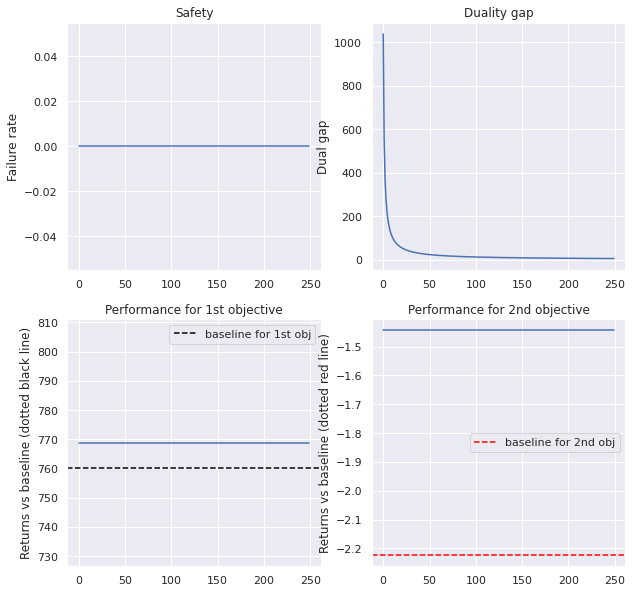

(768.8114901560344, 1.4443252997591498, 0.0)

In [16]:
agent = Lagrangian(None, n_iter=N_ITER, norm_bound=NORM_BOUND, lr_eta=LR_ETA, dual_gap=DUAL_GAP)

agent.make_policy_iteration_operator(P_hat, R_star, C_star, GAMMA, initial_distribution, (1.0,1.0), pi_baseline, P_star, plotting=True)

## Check II: Algorithm works when access to large amount of data 

In this part, we will verify the scenario where the algorithm fails in the low data regime, but when we give it access to the true MDP parameters it is able to compute a solution successfully. This translates to the scenario where the agorithm fails when $\hat{P}$ is given as input, but works fine when $P^{\star}$ is given instead.

 12%|█▏        | 29/250 [00:00<00:01, 141.90it/s]

Iter: 0, Gap: 1039.113, Safe: True


 28%|██▊       | 70/250 [00:00<00:01, 135.07it/s]

Iter: 50, Gap: 27.226, Safe: False


 50%|█████     | 126/250 [00:00<00:00, 133.14it/s]

Iter: 100, Gap: 15.603, Safe: False


 67%|██████▋   | 167/250 [00:01<00:00, 133.23it/s]

Iter: 150, Gap: 11.081, Safe: False


 89%|████████▉ | 223/250 [00:01<00:00, 136.38it/s]

Iter: 200, Gap: 8.559, Safe: False


100%|██████████| 250/250 [00:01<00:00, 134.67it/s]


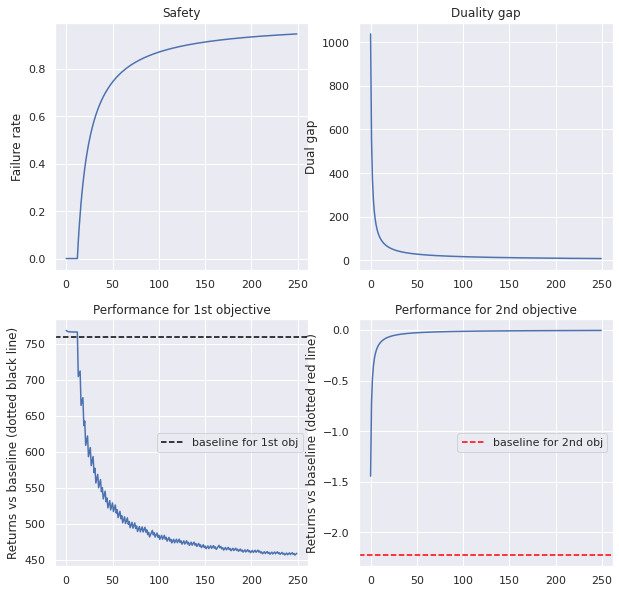

(458.90364185417707, 0.005777301199036505, 0.948)

In [17]:
# we use P_hat here
agent = Lagrangian(None, n_iter=N_ITER, norm_bound=NORM_BOUND, lr_eta=LR_ETA, dual_gap=DUAL_GAP)

agent.make_policy_iteration_operator(P_hat, R_star, C_star, GAMMA, initial_distribution, COEFFS, pi_baseline, P_star, plotting=True)

Now we use $P^{\star}$ instead of $\hat{P}$ but keep the rest of the parameters the same

 18%|█▊        | 46/250 [00:00<00:00, 231.82it/s]

Iter: 0, Gap: 96.881, Safe: False


 32%|███▏      | 81/250 [00:00<00:00, 194.10it/s]

Iter: 50, Gap: 15.807, Safe: True


 54%|█████▎    | 134/250 [00:00<00:00, 181.78it/s]

Iter: 100, Gap: 9.944, Safe: True


 68%|██████▊   | 170/250 [00:00<00:00, 179.09it/s]

Iter: 150, Gap: 7.147, Safe: True


 90%|████████▉ | 224/250 [00:01<00:00, 174.48it/s]

Iter: 200, Gap: 5.498, Safe: True


100%|██████████| 250/250 [00:01<00:00, 179.05it/s]


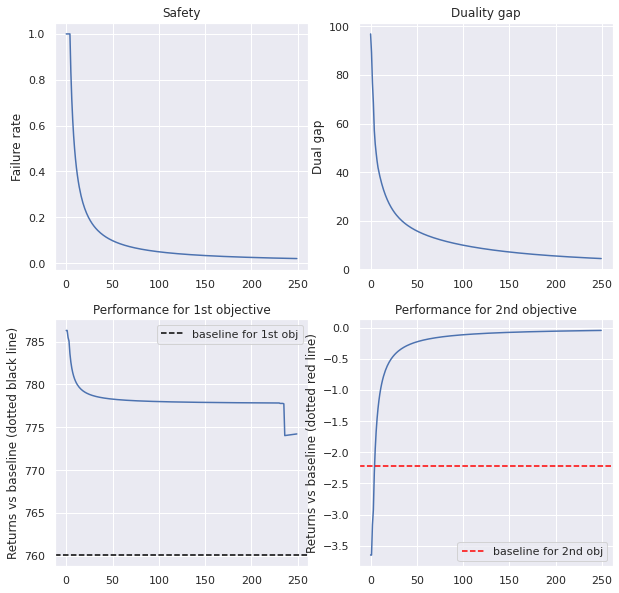

(774.2140666501658, 0.046781762088746945, 0.020000000000000018)

In [18]:
agent = Lagrangian(None, n_iter=N_ITER, norm_bound=NORM_BOUND, lr_eta=LR_ETA, dual_gap=DUAL_GAP)
agent.make_policy_iteration_operator(P_star, R_star, C_star, GAMMA, initial_distribution, COEFFS, pi_baseline, P_star, plotting=True)

# Section 3: High failure rate across all hyper-parameters considered

Here we show that tuning the hyper-parameters can be particularly challenging with respect to this algorithm. For instance, here we show that none of hyper-parameters considered in a large range are able to satisfy safety requirements. 

In [21]:
N_ITER = 250 # also tried 100, 500
DUAL_GAP = 0.01 # also tried 0.001

NORM_BOUND_LIST = [1, 10, 50, 100]
# LR_ETA_LIST = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
LR_ETA_LIST = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]

for norm_bound in tqdm(NORM_BOUND_LIST):
    for lr_eta in tqdm(LR_ETA_LIST, leave=False):
        h_agent = Lagrangian(None, n_iter=N_ITER, norm_bound=norm_bound, lr_eta=lr_eta, dual_gap=DUAL_GAP)
        _,_,fail_rate = h_agent.make_policy_iteration_operator(P_hat, R_star, C_star, GAMMA, initial_distribution, COEFFS, pi_baseline, P_star, plotting=False)
        print(f"Norm:{norm_bound}\t Lr_eta:{lr_eta}\t Fail rate:{fail_rate}")

 14%|█▍        | 1/7 [00:01<00:10,  1.82s/it]

Norm:1	 Lr_eta:0.005	 Fail rate:0.896



 29%|██▊       | 2/7 [00:03<00:09,  1.81s/it]

Norm:1	 Lr_eta:0.01	 Fail rate:0.948



 43%|████▎     | 3/7 [00:05<00:07,  1.80s/it]

Norm:1	 Lr_eta:0.05	 Fail rate:0.988



 57%|█████▋    | 4/7 [00:07<00:05,  1.80s/it]

Norm:1	 Lr_eta:0.1	 Fail rate:0.992



 71%|███████▏  | 5/7 [00:08<00:03,  1.79s/it]

Norm:1	 Lr_eta:0.5	 Fail rate:0.996



 86%|████████▌ | 6/7 [00:10<00:01,  1.78s/it]

Norm:1	 Lr_eta:1.0	 Fail rate:0.996


<ipython-input-9-bf57594858b0>:34: RuntimeWarning: overflow encountered in exp
  unnormalized_wt = self.w_t*np.exp(self.eta*gradient) # positive since working  w/ costs.
<ipython-input-9-bf57594858b0>:34: RuntimeWarning: invalid value encountered in multiply
  unnormalized_wt = self.w_t*np.exp(self.eta*gradient) # positive since working  w/ costs.

  0%|          | 0/7 [00:00<?, ?it/s]

Norm:1	 Lr_eta:5.0	 Fail rate:0.996



 14%|█▍        | 1/7 [00:01<00:11,  1.87s/it]

Norm:10	 Lr_eta:0.005	 Fail rate:0.892



 29%|██▊       | 2/7 [00:03<00:09,  1.85s/it]

Norm:10	 Lr_eta:0.01	 Fail rate:0.948



 43%|████▎     | 3/7 [00:05<00:07,  1.85s/it]

Norm:10	 Lr_eta:0.05	 Fail rate:0.988



 57%|█████▋    | 4/7 [00:07<00:05,  1.81s/it]

Norm:10	 Lr_eta:0.1	 Fail rate:0.992



 71%|███████▏  | 5/7 [00:08<00:03,  1.79s/it]

Norm:10	 Lr_eta:0.5	 Fail rate:0.996



 86%|████████▌ | 6/7 [00:10<00:01,  1.77s/it]

Norm:10	 Lr_eta:1.0	 Fail rate:0.996



  0%|          | 0/7 [00:00<?, ?it/s]

Norm:10	 Lr_eta:5.0	 Fail rate:0.996



 14%|█▍        | 1/7 [00:01<00:11,  1.86s/it]

Norm:50	 Lr_eta:0.005	 Fail rate:0.892



 29%|██▊       | 2/7 [00:03<00:09,  1.86s/it]

Norm:50	 Lr_eta:0.01	 Fail rate:0.944



 43%|████▎     | 3/7 [00:05<00:07,  1.86s/it]

Norm:50	 Lr_eta:0.05	 Fail rate:0.988



 57%|█████▋    | 4/7 [00:07<00:05,  1.83s/it]

Norm:50	 Lr_eta:0.1	 Fail rate:0.992



 71%|███████▏  | 5/7 [00:09<00:03,  1.79s/it]

Norm:50	 Lr_eta:0.5	 Fail rate:0.996



 86%|████████▌ | 6/7 [00:10<00:01,  1.76s/it]

Norm:50	 Lr_eta:1.0	 Fail rate:0.996



  0%|          | 0/7 [00:00<?, ?it/s]

Norm:50	 Lr_eta:5.0	 Fail rate:0.996



 14%|█▍        | 1/7 [00:01<00:11,  1.87s/it]

Norm:100	 Lr_eta:0.005	 Fail rate:0.892



 29%|██▊       | 2/7 [00:03<00:09,  1.87s/it]

Norm:100	 Lr_eta:0.01	 Fail rate:0.944



 43%|████▎     | 3/7 [00:05<00:07,  1.86s/it]

Norm:100	 Lr_eta:0.05	 Fail rate:0.988



 57%|█████▋    | 4/7 [00:07<00:05,  1.83s/it]

Norm:100	 Lr_eta:0.1	 Fail rate:0.992



 71%|███████▏  | 5/7 [00:09<00:03,  1.79s/it]

Norm:100	 Lr_eta:0.5	 Fail rate:0.996



 86%|████████▌ | 6/7 [00:10<00:01,  1.76s/it]

Norm:100	 Lr_eta:1.0	 Fail rate:0.996



100%|██████████| 4/4 [00:45<00:00, 11.28s/it]

Norm:100	 Lr_eta:5.0	 Fail rate:0.996


Note that in the above case the failure rate is high regardless of the hyper-parameter combination. This is expected as Le et al (2019) don't have any practical guarantees for their methods. In the low data setting, when the concentrability assumption is violated, we can observe that their method fails to have a low failre rate.

In [20]:
# %debug